# Lupus III

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Lupus/'
name = 'lupIII'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + 'HGBS_' + name + '_column_density_map.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

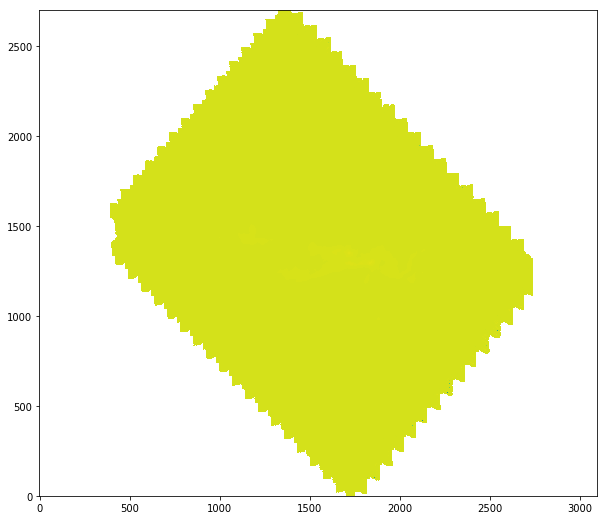

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to -2.253e+21 [aplpy.core]
INFO: Auto-setting vmax to  7.181e+21 [aplpy.core]


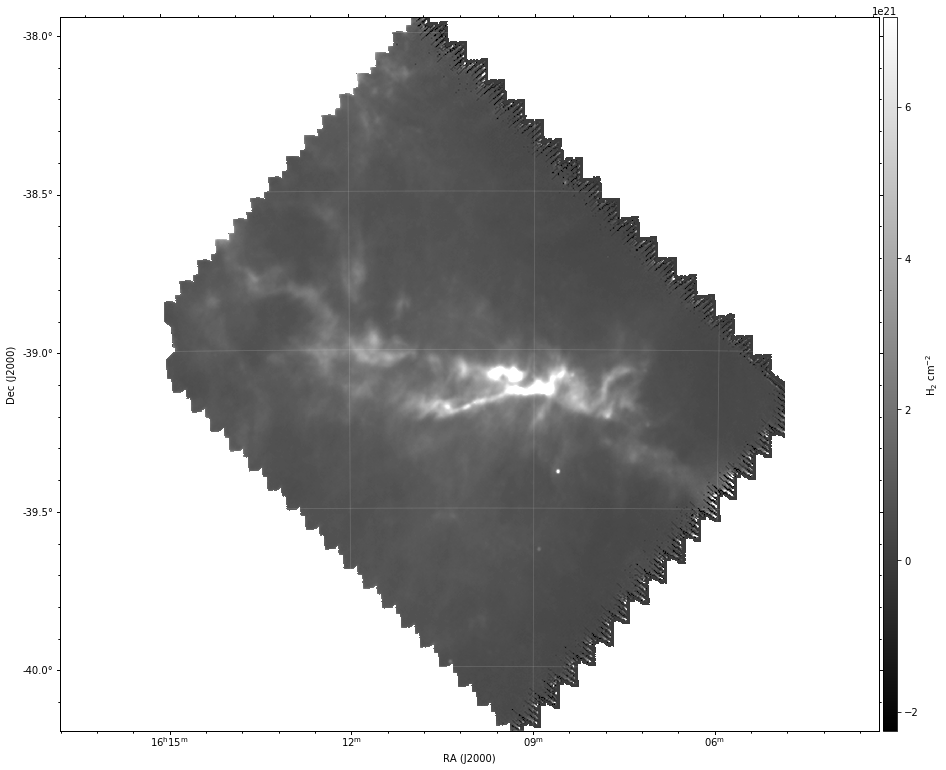

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [7]:
header

SIMPLE  =                    T / Written by IDL:  Wed Jan 17 15:16:53 2018      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3100                                                  
NAXIS2  =                 2700                                                  
COMMENT Science data image                                                      
CREATOR = 'IDL               '                                                  
TELESCOP= 'Herschel Space Observatory'                                          
INSTRUME= 'SPIRE/PACS'                                                          
PROPOSAL= 'KPGT_pandre_1'                                                       
PRTITLE = 'Herschel Gould Belt Survey (HGBS)'                                   
COMMENT Reference publication of the survey: Andre' et al. (2010)               
COMMENT bibcode: 2010A&A...5

In [9]:
import reproject as proj

In [10]:
hdproj = header.copy()

ratio = 0.00388889/0.00083333333333333

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
#Rotate the map
hdproj['CROTA1'] = -49.9016
hdproj['CROTA2'] = -49.9016


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [11]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to -2.287e+21 [aplpy.core]
INFO: Auto-setting vmax to  8.634e+21 [aplpy.core]


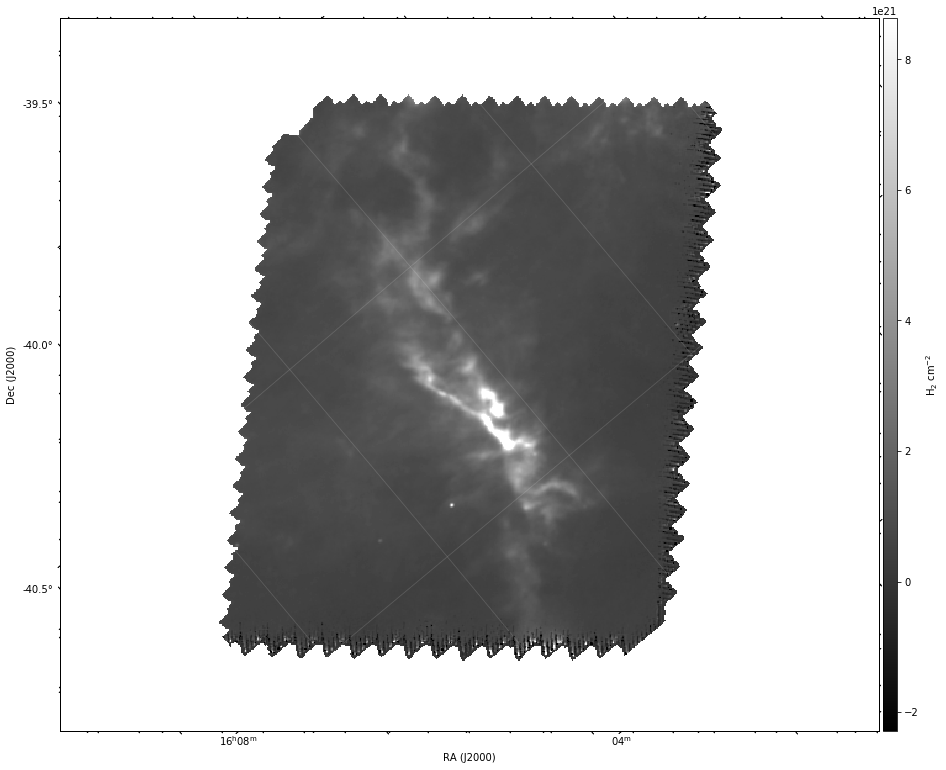

In [12]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [13]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header

In [14]:
#Cut the map
input = path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([207,88,483,504])
#coords = np.array([171,439,470,897])
subfits(input,output,coords)

Dimensions 277 417


In [15]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -5.221e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.026e+22 [aplpy.core]


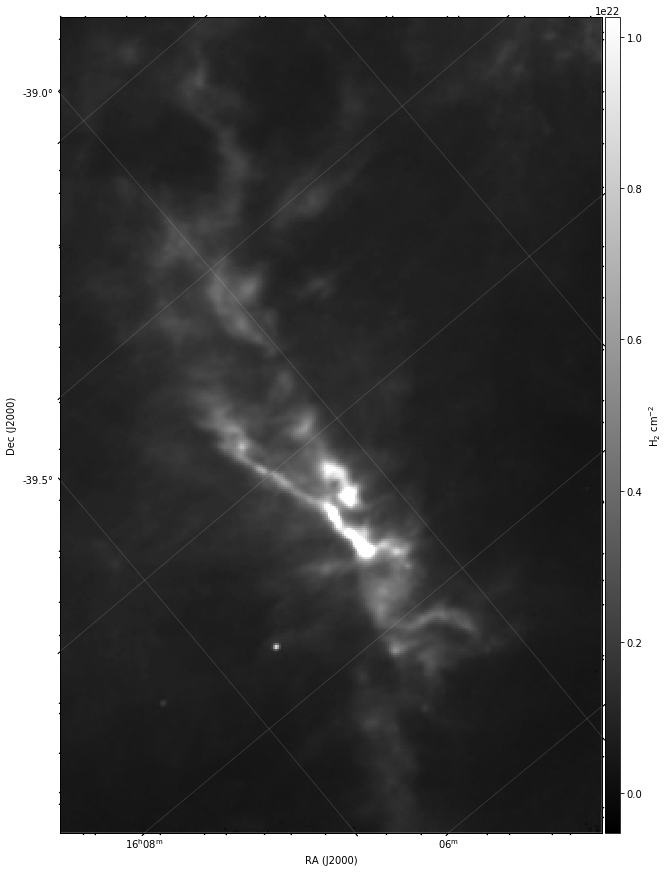

In [16]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

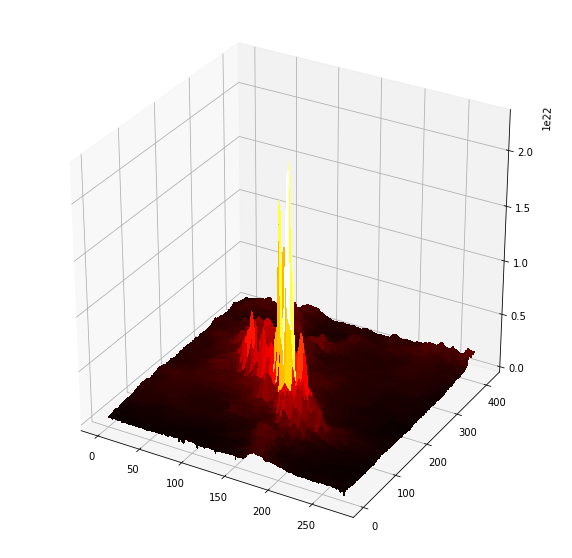

In [17]:
from mpl_toolkits.mplot3d import Axes3D
dim2=im.shape[0]
dim1=im.shape[1]
X=np.linspace(0,dim1-1,dim1)
Y=np.linspace(0,dim2-1,dim2)
X,Y=np.meshgrid(X,Y)
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
#ax.set_zlim([-0.3,0.3])
ax.plot_surface(X,Y,im,cmap='hot',antialiased=False)
#ax.view_init(45,45)

In [18]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((550,400))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [19]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

400 550


Text(0.5, 1.0, 'Beam power spectrum')

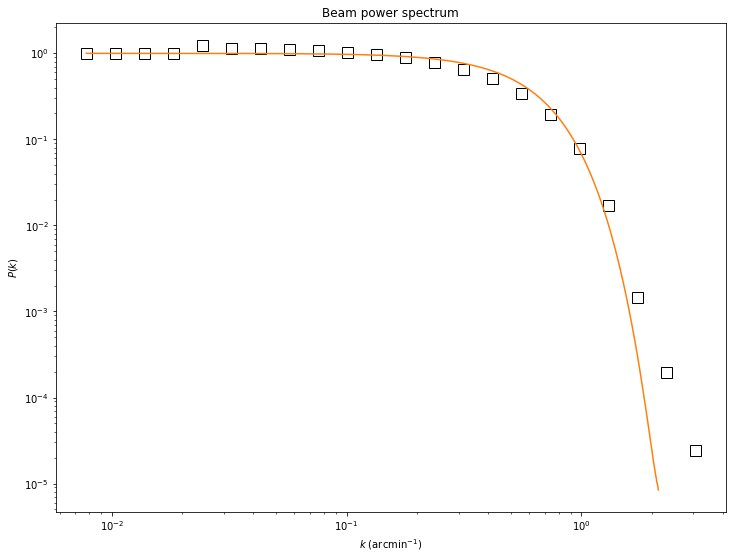

In [20]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  1.4887816042130659e+41 -2.2471190611513645 0.0
Gaussian wavelet
A, Gamma, P0 =  1.65558e+38 -2.03236 2.02255e+39


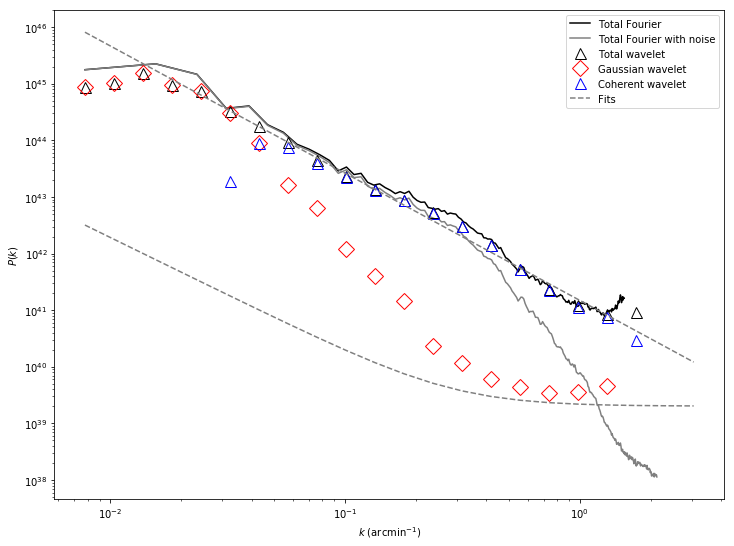

In [32]:
Noise = spec_k[-1]

#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.00165558e+41, -2.03236, 0.0202255e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, cov = np.polyfit(np.log(wav_k[7:19]), np.log((S1a[1,7:19]-Noise)/BS1an[7:19]),deg=1,cov=True)
fit_cohe=np.exp(A_cohe[1])*wav_k**A_cohe[0]

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', np.exp(A_cohe[1]), A_cohe[0], 0.0)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)


plt.figure(figsize(12,9))
plt.plot(tab_k[:-75], (spec_k[:-75]-Noise)/spec_beamn2[:-75], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

plt.savefig(path + 'HGBS_' + name + '_column_density_map_power_spec.png', dpi=500)

In [28]:
np.std((S1a[2,:]-Noise)/BS1an/1e41)

4473.703569768186

In [22]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, header, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, header, overwrite=True)

INFO: Auto-setting vmin to -2.244e+21 [aplpy.core]
INFO: Auto-setting vmax to  6.974e+21 [aplpy.core]
INFO: Auto-setting vmin to -1.128e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.056e+21 [aplpy.core]


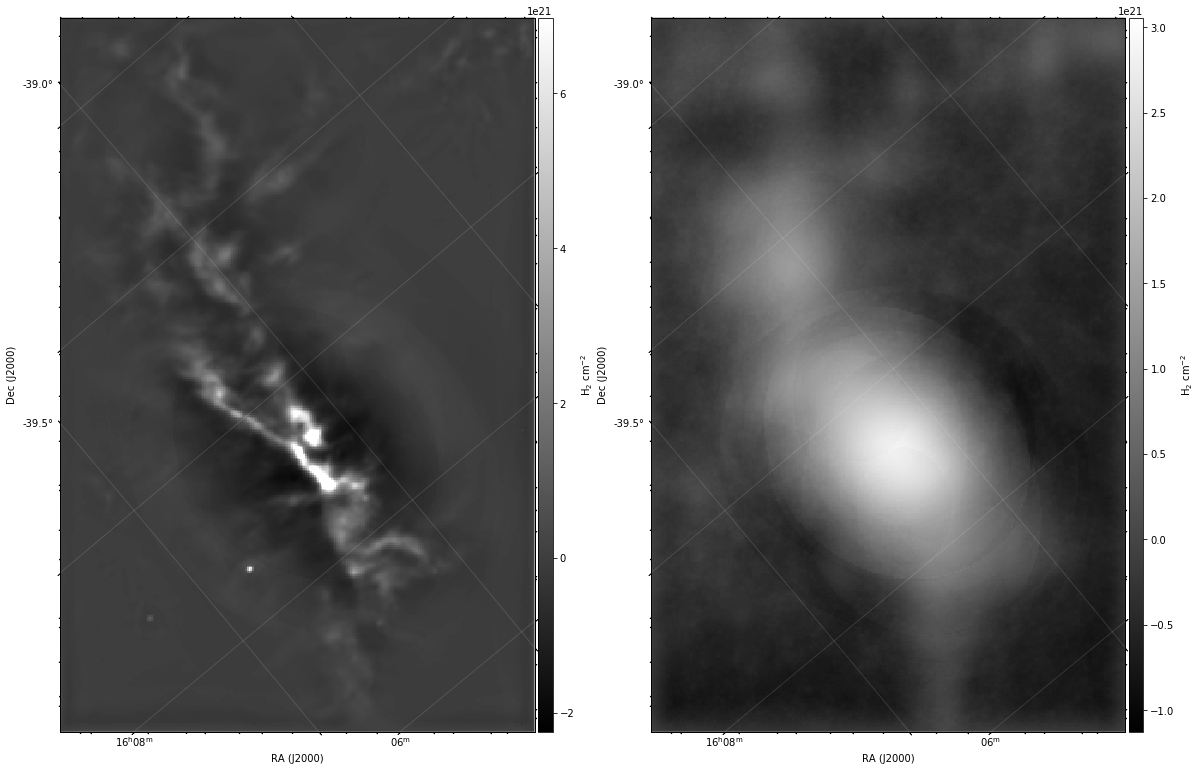

In [23]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits',figure=fig_all, subplot=(1,3,1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits',figure=fig_all, subplot=(1,3,2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')